In [72]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

img_path = "img/2_.jpg"

img_read = cv2.imread(img_path)
cv2.imshow("Original Image", img_read)
cv2.waitKey(0)
cv2.destroyAllWindows()


## Convert BGR to HSV

In [73]:
import cv2
import numpy as np

# Detect image size
row, col = img_read.shape[:2]
# Convert BGR to HSV
def BGR2HSV(image):
    # Create empty array for placeholder
    h = np.zeros((row, col), dtype=np.uint32)
    s = np.zeros((row, col), dtype=float)
    v = np.zeros((row, col), dtype=float)
    
    # Start calculation (looping)
    for i in range(row):
        for j in range(col):
            currentPixel = image[i, j]
            # Normalize the pixel
            b = currentPixel[0] / 255
            g = currentPixel[1] / 255
            r = currentPixel[2] / 255
            
            # Start calculation (https://youtu.be/QRssbkMmB50?si=RWli19HjF_HginxQ)
            cmax = np.max([b, g, r])
            cmin = np.min([b, g, r])
            difference = cmax - cmin
            
            # Hue Calc
            if cmax == cmin:
                h[i,j] = 0
            elif cmax == r:
                h[i,j] = (60 * ((g - b) / difference)) % 360
            elif cmax == g:
                h[i,j] = (60 * ((b - r) / difference) + 120) % 360
            elif cmax == b:
                h[i,j] = (60 * ((r - g) / difference) + 240) % 360
            
            # Saturation Calc
            if cmax == 0:
                s[i,j] = 0
            else:
                s[i,j] = (difference / cmax)
            
            # Value Calc
            v[i,j] = cmax
    
    return h, s, v

# Normalization (https://github.com/zain-ul-abaidin/Digital-Image-Processing/blob/82cf59eb81acfca01f66cb860d9dc336aba9b251/BGR2HSV-Hue-Saturation-Intensity-without-Build-in.py#L44)
def normalization(out):
    minimum = np.min(out)
    maximum = np.max(out)
    normImg = np.zeros((row, col), dtype=np.uint8)
    for i in range(0, row):
        for j in range(0, col):
            # Using Normalization Formula
            normImg[i][j] = (255*(out[i][j]-minimum))//(maximum-minimum)
    return normImg

h,s,v = BGR2HSV(img_read)
norm_s = normalization(s)
cv2.imshow("BGR to HSV", norm_s)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Gaussian Blur

In [74]:
def convolution(image: np.ndarray, kernel: list | tuple )-> np.ndarray:
    if len(image.shape) == 3:
        H,W,C = image.shape
    
    elif len(image.shape) == 2:
        image = image[..., np.newaxis]
        H,W,C = image.shape
    else:
        raise ValueError("Image shape must be 2 or 3")
    
    h_k, w_k = kernel.shape

    y_strides = H - h_k + 1
    x_strides = W - w_k + 1

    img = image.copy()
    output_shape = (y_strides, x_strides, C)
    output = np.zeros(output_shape, dtype=np.float32)

    count=0

    output_tmp = output.reshape(
        (output_shape[0]*output_shape[1], output_shape[2])
    )

    for i in range(y_strides):
        for j in range(x_strides):
            for c in range(C):
                sub_matriks = img[i:i+h_k, j:j+w_k, c]

                output_tmp[count, c] = np.sum(sub_matriks * kernel)
            
            count += 1
    

    output = output_tmp.reshape(output_shape)

    return output

In [75]:
def gausssian_blur(img: np.ndarray, sigma: float|int, filter_shape: list | tuple | None = None):
    if filter_shape is None:
        _ = 2*int(4*sigma+0.5)+1
        filter_shape = (_,_)
    
    elif len(filter_shape) != 2:
        raise ValueError("Filter shape must be 2")
    
    m, n = filter_shape

    m_half = m // 2
    n_half = n // 2

    gaussian_filter = np.zeros(filter_shape, np.float32)

    for i in range(-m_half, m_half):
        for j in range(-n_half,n_half):
            normal = 1/(2.0 * np.pi * sigma**2.0)
            exp_term = np.exp(-(i**2 + j**2) / (2.0 * sigma**2.0))
            gaussian_filter[i+m_half, j+n_half] = normal * exp_term
    
    blur_img = convolution(img, gaussian_filter)

    return gaussian_filter, blur_img

In [76]:
img = s

g_filter, blur_img = gausssian_blur(img, 2.5, (5,5))

cv2.imshow("Blur Image using Gaussian Filter", blur_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Thresholding

In [77]:
def threshold(thresValue, imgValue):
    # copy image using zeros
    img_copy = np.ones(thresValue.shape).astype(np.uint8)
    # thresholding
    img_copy[np.where(thresValue > imgValue)] = 255
    return img_copy

# # otsu threshold gak kepake le kawkoawko
# def otsu_threshold(img, max_L):
#     M = np.product(img.shape)
#     min_var = []
#     hist_t = np.histogram(img, bins=256, range=(0,256))
    
#     img_t = threshold(img, 0)
    
#     for L in np.arange(1, max_L):
#         img_ti = threshold(img, L)
#         # compute weight
#         w_a = np.sum(hist_t[0][:L]) / M
#         w_b = np.sum(hist_t[0][L:]) / M
        
#         # compute variant
#         sig_a = np.var(img[np.where(img_ti == 0)])
#         sig_b = np.var(img[np.where(img_ti == 1)])
        
#         min_var = min_var + [w_a * sig_a + w_b * sig_b]

#     img_t = threshold(img, np.argmin(min_var))
#     return img_t, np.argmin(min_var)

# img_o, oL = otsu_threshold(blur_img, 255)
# thresholderrr = np.zeros_like(blur_img)
# thresholderrr[:] = 235

mask_1 = threshold(blur_img, np.mean(blur_img)-.075)
print(mask_1.shape)

cv2.imshow("Threshold Image", mask_1)
cv2.waitKey(0)
cv2.destroyAllWindows()

(464, 476, 1)


# Image Segmentation

## change the color to grey

In [78]:
def rgb2gray(image):
    H,W = image.shape[:2]
    gray = np.zeros((H,W), np.uint8)
    for i in range(H):
        for j in range(W):
            gray[i,j] = np.clip(0.07 * image[i,j,0]  + 0.72 * image[i,j,1] + 0.21 * image[i,j,2], 0, 255)

    return gray

In [79]:
gray_img = rgb2gray(img_read)
cv2.imshow("Image to Gray", gray_img)
cv2.waitKey(0) 
cv2.destroyAllWindows()

## Sobel equation for Edge Detection

In [80]:
def apply_sobel(image):
    # Define the Sobel kernels
    Kx = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]], dtype=np.float32)

    Ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]], dtype=np.float32)

    # Get the dimensions of the image
    rows = image.shape[0]
    cols = image.shape[1]
    print(rows, cols)

    # Initialize the gradient images
    Gx = np.zeros_like(image, dtype=np.float32)
    Gy = np.zeros_like(image, dtype=np.float32)

    # Apply the Sobel operator
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            region = image[i - 1:i + 2, j - 1:j + 2]
            Gx[i, j] = np.sum(Kx * region)
            Gy[i, j] = np.sum(Ky * region)
            
            

    # Compute the magnitude of the gradient
    G = np.sqrt(Gx ** 2 + Gy ** 2)    
    G = (G / G.max()) * 255  # Normalize to 0-255
    G = G.astype(np.uint8)

    return G

## Erode

In [81]:
import cv2 as cv
import numpy as np

class erode:
    def __init__(self, img):
        self.size = 19
        self.kernel = np.ones((self.size, self.size), np.uint8)
        self.p_size = self.size//2
        self.rows = img.shape[0]
        self.columns = img.shape[1]
        
        self.padImg = self.padding(img)
        self.erotionImg = self.Erosion(self.padImg)

    # padding
    def padding(self, originalImg):
        padImg = np.zeros((self.rows+2*self.p_size, self.columns+2*self.p_size), dtype=np.uint8)
        # using Slicing
        padImg[self.p_size:self.rows+self.p_size, self.p_size:self.columns+self.p_size] = originalImg
        return padImg
    
    # Morphological Erosion
    def Erosion(self, padImg):
        output = np.zeros((self.rows, self.columns), dtype=np.uint8)
        for i in range(0, self.rows):
            for j in range(0, self.columns):
                # Slicing
                portion = padImg[i:i+self.size, j:j+self.size]
                portion1 = portion.flatten()
                portion2 = self.kernel.flatten()
                # sum of kernel and window
                p1 = (np.sum(portion1))
                p2 = (np.sum(portion2))*255
                # if Fit condition satisfies
                if p1 == p2:
                    output[i, j] = 255
                else:
                    output[i, j] = np.min(portion1)
        return output


## Dilated

In [82]:
import cv2 as cv
import numpy as np

class dilation:
    def __init__(self, img):
        self.size = 5
        self.kernel = np.ones((self.size, self.size), np.uint8) # Structuring Element along with the size 
        self.p_size = self.size//2 # padding size 
        self.rows = img.shape[0] # getting size of image
        self.columns = img.shape[1]
        self.img = img
        
        self.padded_Img = self.padding(self.img)  # Call padding on the instance
        self.dilation_result = self.Dilation(self.padded_Img)
        
    # padding
    def padding(self, img):
        padImg = np.zeros((self.img.shape[0] + 2 * self.p_size, self.img.shape[1] + 2 * self.p_size), dtype=np.uint8)
        padImg[self.p_size:self.p_size + self.img.shape[0], self.p_size:self.p_size + self.img.shape[1]] = self.img
        return padImg
    
    def Dilation(self, padded_img):
        output = np.zeros((self.rows, self.columns), dtype=np.uint8)
        for i in range(0, self.rows):
            for j in range(0, self.columns):
                # Slicing
                portion = padded_img[i:i+self.size, j:j+self.size]
                portion1 = portion.flatten()
                # if Hit Condition Satisfies
                if 255 in portion1:
                    output[i, j] = 255
                else:
                    output[i, j] = np.max(portion1)
        return output


## Opening Closing

In [83]:
import cv2 as cv
import numpy as np

class open_close:
    def __init__(self, img):
        self.size = 5
        self.kernel = np.ones((self.size, self.size), np.uint8) # Structuring Element along with the size 
        self.p_size = self.size//2 # padding size 
        self.rows = img.shape[0] # getting size of image
        self.columns = img.shape[1]
        self.img = img
        
        # self.padImg = self.padding(img)
        
    def padding(self, img):
        padImg = np.zeros((self.img.shape[0] + 2 * self.p_size, self.img.shape[1] + 2 * self.p_size), dtype=np.uint8)
        padImg[self.p_size:self.p_size + self.img.shape[0], self.p_size:self.p_size + self.img.shape[1]] = self.img
        return padImg
        
    def opening(self, img):
        padImage = self.padding(img)
        # First apply Erosion
        erosion = erode.Erosion(self, padImg=padImage)
        padImg2 = self.padding(erosion)
        # secondly apply Dilation on Eroded
        output = dilation.Dilation(self, padImg2)
        return output

    def closing(self, img):
        padImage = self.padding(img)
        # First apply Dilation
        dilati_ = dilation.Dilation(self, padded_img=padImage)
        padImg2 = self.padding(dilati_)
        # secondly apply Erosion on Dilated
        output = erode.Erosion(self, padImg2)
        return output

## Fingernail Mask

In [84]:
# Apply Edge Detection
edge_img = apply_sobel(gray_img)
cv2.imshow("Edge Detection using Sobel", edge_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Apply Dilate
Dilated_img = dilation(edge_img) # Morphological Erosion
dilation_res = Dilated_img.dilation_result

# Apply Threshold
thres_dilate = threshold(dilation_res, np.mean(dilation_res))

# Apply Dilate
dilate_thres = dilation(thres_dilate)
dilate_thres_res = dilate_thres.dilation_result

# Apply Opening (Erode -> Dilate)
open_container = open_close(dilate_thres_res)
open = open_container.opening(img=dilate_thres_res)

# Apply Closing (Dilate -> Erode)
close_container = open_close(open)
close = close_container.closing(img=open)

cv2.imshow("Dilate > Threshold > Dilate > Opening > Closing", close)
cv2.waitKey(0)
cv2.destroyAllWindows()

468 480


## Masking Fingernail_Mask with Upper Mask

In [85]:
m_1 = mask_1 #threshold
m_2 = close #hasil segmentasi

# if mask_1 have higher dimension, then convert it to 2D
if len(mask_1.shape) == 2:
    m_1 = mask_1[:, :, np.newaxis]
elif len(close.shape) == 2:
    m_2 = close[:, :, np.newaxis]

# ================ AND BITWIZE FOR PREPARATION MASKING =================
# as we know the mask_2 shape is higher than mask_1, then we create zeros like mask_1
zeros_mask = np.zeros_like(m_2)
zeros_mask = np.repeat(zeros_mask, 3, axis=-1)

# ================ MASKING ORIGINAL IMAGE USING OR OPERATION =================
for w in range(m_1.shape[0]):
    for h in range(m_1.shape[1]):
        if m_1[w, h] == 255 & m_2[w, h] == 255:
            zeros_mask[w, h] = 255
        elif m_1[w, h] == 0 & m_2[w, h] == 255:
            zeros_mask[w, h] = 0
        else:
            zeros_mask[w, h] = 0

# ================ MASKING ORIGINAL IMAGE USING OR OPERATION =================
# Replicate higher dimension like zeros_mask to copy lower dimension (threshold_mask)
zero_repli = np.zeros_like(zeros_mask)
for w in range(zeros_mask.shape[0]):
    for h in range(zeros_mask.shape[1]):
        for z in range(zeros_mask.shape[2]):
            try:
                if m_1[w, h] == 255:
                    zero_repli[w, h, z] = 255
                else:
                    zero_repli[w, h, z] = 0
            except:
                pass

# Masking image using threshold mask
zero_img = np.zeros_like(img_read)
for w in range(img_read.shape[0]):
    for h in range(img_read.shape[1]):
        if zeros_mask[:,:,0][w, h] == 255:
            zero_img[:,:,0][w, h] = 0 
            zero_img[:,:,1][w, h] = 0
            zero_img[:,:,2][w, h] = 0
        else:
            zero_img[:,:,0][w, h] = img_read[:,:,0][w, h]
            zero_img[:,:,1][w, h] = img_read[:,:,1][w, h]
            zero_img[:,:,2][w, h] = img_read[:,:,2][w, h]
        # for z in range(img_read.shape[2]):


img_masked = zero_img[:,:,:]         
for w in range(img_read.shape[0]):
    for h in range(img_read.shape[1]):
        if zero_repli[:,:,0][w, h] == 255:
            img_masked[:,:,0][w, h] = img_masked[:,:,0][w, h]
            img_masked[:,:,1][w, h] = img_masked[:,:,1][w, h]
            img_masked[:,:,2][w, h] = img_masked[:,:,2][w, h]
        else:
            img_masked[:,:,0][w, h] = 0
            img_masked[:,:,1][w, h] = 0
            img_masked[:,:,2][w, h] = 0
            
                

#  GET COLOR RANGE
# img_read_copy = img_read.copy()
h_t, s_t, v_t = BGR2HSV(img_masked)
found_counter = 0
hue_list = [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50] #diabetes hue range
for w in range(img_masked.shape[0]):
    for h in range(img_masked.shape[1]):
        if img_masked[w][h][0] == 0 & img_masked[w][h][1] == 0 & img_masked[w][h][0] == 0:
            pass
        else:
            if h_t[w][h] in hue_list:
                found_counter += 1
                img_read[w][h][0] = 255
                img_read[w][h][1] = 0
                img_read[w][h][2] = 0
        # for z in range(img_masked.shape[2]):

cv2.imshow("Fingernail Detected!", img_masked)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imshow("Final", img_read)
cv2.waitKey(0)
cv2.destroyAllWindows()


## Clasification

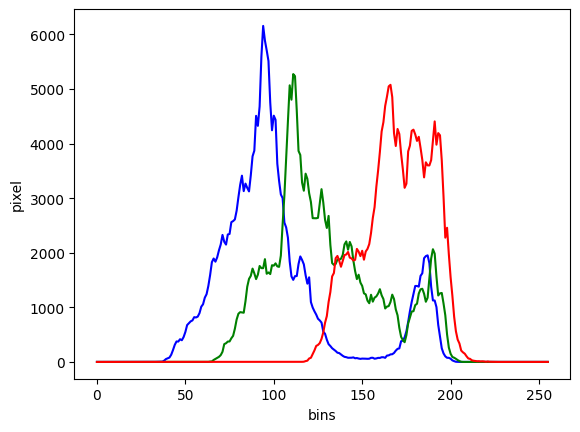

In [86]:
if found_counter > 10:
    img_read_copy = cv2.imread(img_path)    
    # cv2.imshow("Original Image", img_read_copy)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # list of color range
    # fasting_value = np.array(([[i for i in range(15,31)],
    #                            [i for i in range(97,115)], #97,115
    #                            [i for i in range(152,170)]],   #prediabetes -> b,g,r
    #                           [[i for i in range(82,100)],
    #                            [i for i in range(96,114)], #96,114
    #                            [i for i in range(145,161)]]), dtype=object)  #diabetes -> b,g,r
    
    # nonfasting_value = np.array(([[i for i in range(90,111)],
    #                               [i for i in range(103,124)], #103,124
    #                               [i for i in range(170,186)]],   #prediabetes -> b,g,r
    #                              [[i for i in range(93,114)],
    #                               [i for i in range(100,120)], #100,120
    #                               [i for i in range(160,182)]]), dtype=object)  #diabetes    -> b,g,r
    # result = []
    # for w in range(img_read_copy.shape[0]):
    #     for h in range(img_read_copy.shape[1]):
    #         if img_read[w][h][0] == 255: 
    #             # print(img_read_copy[w][h][1])
    #             if img_read_copy[w][h][0] == int(np.median(fasting_value[0][:][0])):
    #                 if img_read_copy[w][h][1] <= (int(np.max(fasting_value[0][:][1])) + 20):
    #                     if img_read_copy[w][h][2] <= int(np.max(fasting_value[0][:][2])):
    #                         result.append("Prediabetes - Fasting")
    #                         # print("Prediabetes - Fasting")
            
    #             elif img_read_copy[w][h][0] == int(np.median(fasting_value[1][:][0])):
    #                 if img_read_copy[w][h][1] <= (int(np.max(fasting_value[1][:][1])) + 20):
    #                     if img_read_copy[w][h][2] <= int(np.max(fasting_value[1][:][2])):
    #                         result.append("Diabetes - Fasting")
    #                         # print("Diabetes - Fasting")
                    
    #             elif img_read_copy[w][h][0] == int(np.median(nonfasting_value[0][:][0])):
    #                 if img_read_copy[w][h][0] <= (int(np.max(nonfasting_value[0][:][1])) + 20):
    #                     if img_read_copy[w][h][2] <= int(np.max(nonfasting_value[0][:][2])):
    #                         result.append("Prediabetes - Non-Fasting")
    #                         # print("Prediabetes - Non-Fasting")
                    
    #             elif img_read_copy[w][h][0] == int(np.median(nonfasting_value[1][:][0])):
    #                 if img_read_copy[w][h][0] <= (int(np.max(nonfasting_value[1][:][1])) + 20):
    #                     if img_read_copy[w][h][2] <= int(np.max(nonfasting_value[1][:][2])):
    #                         result.append("Diabetes - Non-Fasting")
    #                         # print("Diabetes - Non-Fasting")
    
    img_h = cv2.imread(img_path, cv.COLOR_BGR2RGB)
    plt.figure()
    colors = ['b', 'g', 'r']
    for i in range(3):
        hist = cv.calcHist([img_h], [i], None, [256], [0,256])
        plt.plot(hist, colors[i])
    
    plt.xlabel('bins')
    plt.ylabel('pixel')
    
    plt.show()